# Single Cell Biology 
## Mini project : RNA-seq of fly ovaries dataset 

### Gianna Biino, Marianne Scoglio, Gabrielle Blouvac

### Imports 

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter("ignore", category=pd.errors.PerformanceWarning)

### Snapshot analysis of the Fly Cell Atlas
#### The Ovaries
This project analyses the dataset of the fly cell atlas, containing the single cell transcriptome of the fly's ovaries.
The goal of this project is to research the cell-types and marker genes found in the ovaries.
The data used has already been preprocessed so we will focus on the downstream analysis.

### 0) Data loading 

In [3]:
adata = sc.read_csv("ovary.tsv", delimiter = '\t', first_column_names=True)
adata = adata.T
adata

AnnData object with n_obs × n_vars = 7549 × 11944

##### QC and filtering
In order to analyse the data we perform some quality control and filtering first in order to remove poor quality data.

### 1) Preprocessing 

In [4]:
sc.settings.seed=2

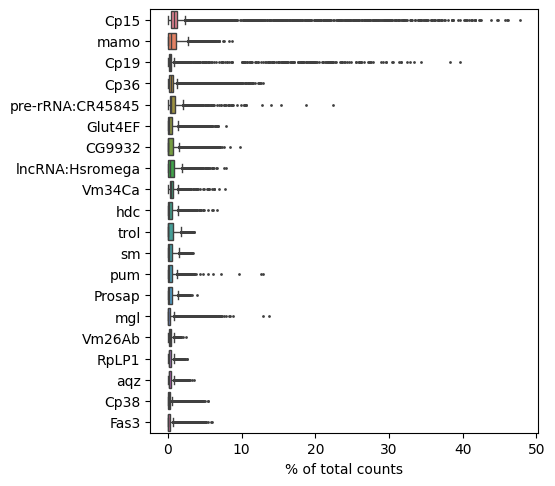

In [5]:
# look at the highest expressed genes
sc.pl.highest_expr_genes(adata, n_top=20)

TODO: COMMENT (like Chorion membrane (egg shell) protein: plays a role in protecting the egg from the environment.)

#### Filtering the cells 

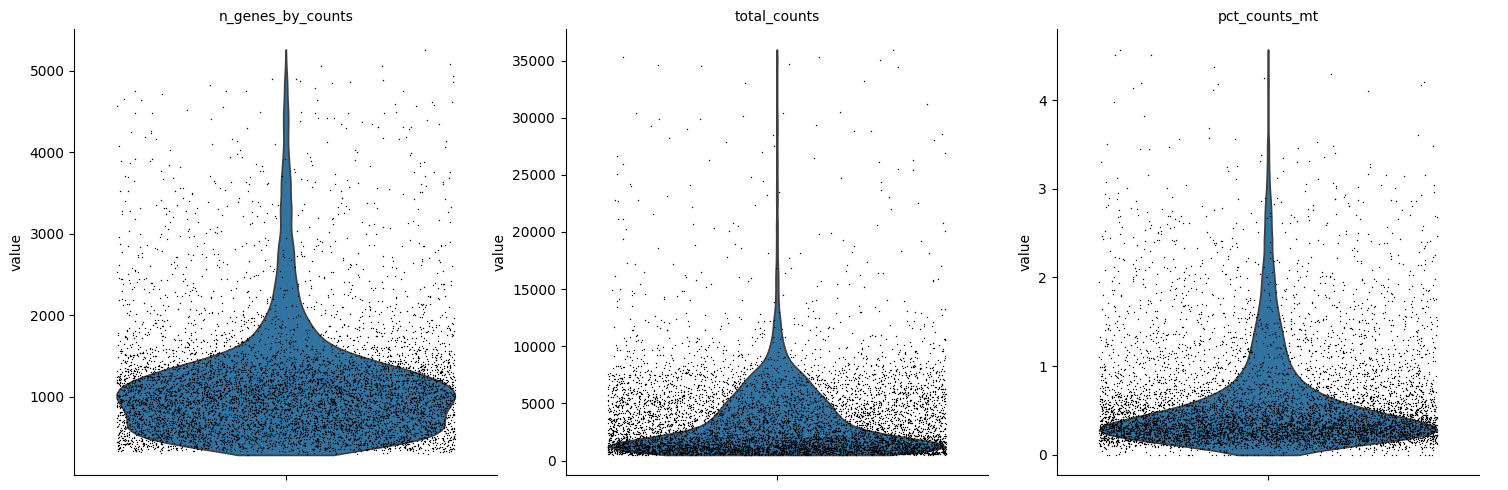

In [6]:
#filter out cells with low gene count and genes that are detected in 3 or less cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt" 
adata.var["mt"] = adata.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

# Violin plot to look at the number of genes and cells
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

We filter out cells with low gene counts, which may represent empty droplets, and remove genes detected in three or fewer cells. The percentage of mitochondrial gene counts remains below five, suggesting that the detected cells are healthy and that we do not need to filter them. For now, we do not filter for doublets, as no cells exhibit aberrant gene counts. However, we will assess this further in the UMAP visualization to determine whether high gene counts influence clustering.

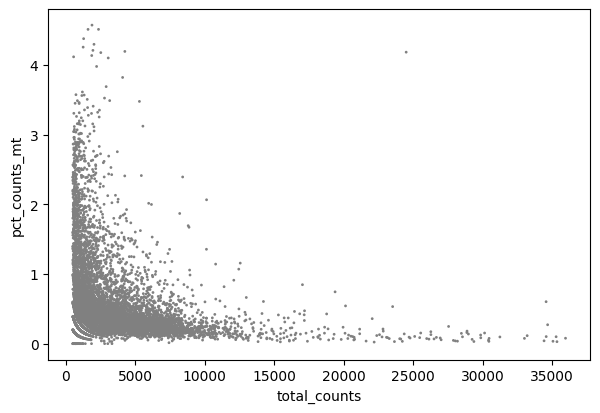

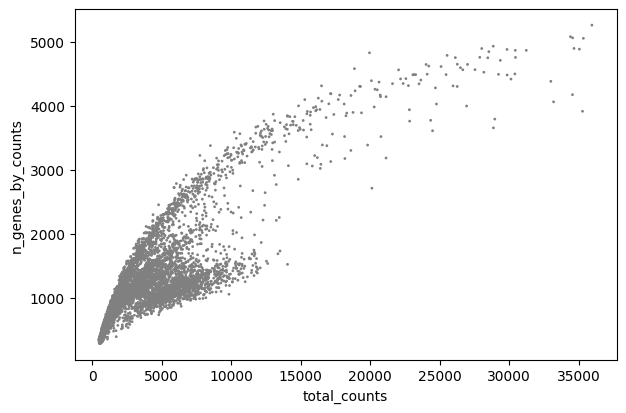

In [7]:
#scatter plots
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

TODO comment plots

#### Normalization 
In order to be able to compare the gene counts we normalize the data and regress out the effect of the counts per cell and percentage of mitochondrial genes expressed.

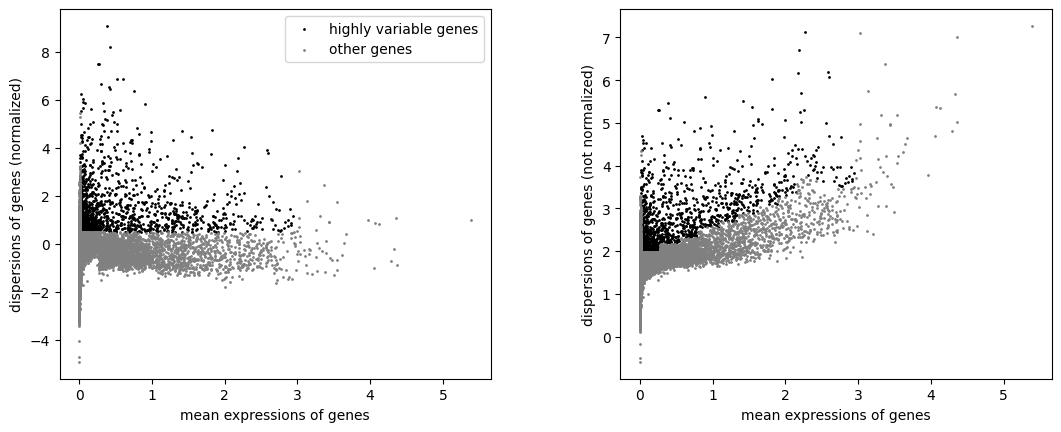

In [8]:
#normalize the total count so that the counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)
# take the log of the data
sc.pp.log1p(adata)

#look at the highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #TODO: check params
sc.pl.highly_variable_genes(adata)

In [9]:
# Set the .raw attribute to the normalized and logarithmized raw gene expression
adata.raw = adata.copy()

# Regress out effects of total count per cell
sc.pp.regress_out(adata, ["total_counts"])
# Scale the values
sc.pp.scale(adata, max_value=10)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We do not regress out the mitochondrial genes as stated above 

### 2 ) Principal Component Analysis
We run a PCA on the data in order to analyse the variation in the data

In [10]:
#compute the PCA
sc.tl.pca(adata, svd_solver="arpack")

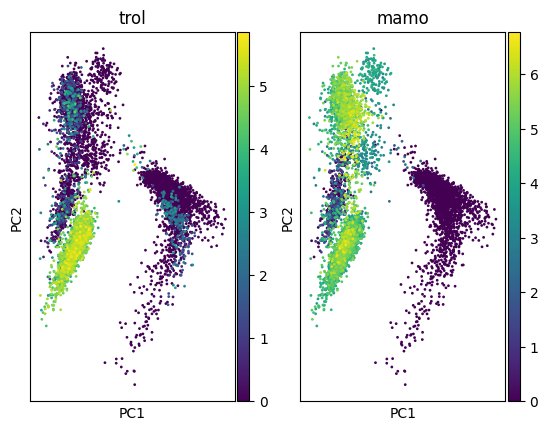

In [11]:
# plot the PCA for the gene Cp15 and mamo 
# TODO choose genes, description does not match
fig, axes = plt.subplots(1,2)
sc.pl.pca(adata, color="trol", ax=axes[0], show=False)
sc.pl.pca(adata, color="mamo", ax=axes[1], show=False)
plt.show()

We see that there is not a big difference of the expression of Cp15 between cells. Mamo however is highly expressed in some cells while not expressed in others.
These two plots only consider the first two principal components though. We have to inspect the contributions of each PC in order to consider as much of the variance as possible.

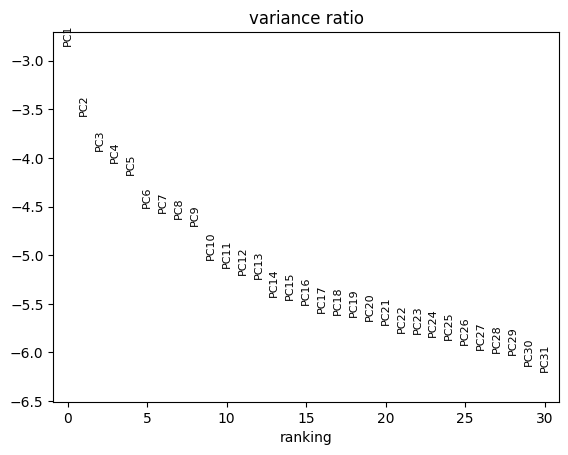

In [12]:
sc.pl.pca_variance_ratio(adata, log=True)

TODO decide how many and comment

#### Computing neighborhood graph 
using PCA representation

In [13]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=14)

/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


explain we kept 25 
same result ish with 14 but can see clusters better 

In [14]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=2,
    flavor="igraph",
    #n_iterations=2,
    directed=False,
)

### 3) Looking at the data : UMAPs & TSNEs

In [15]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

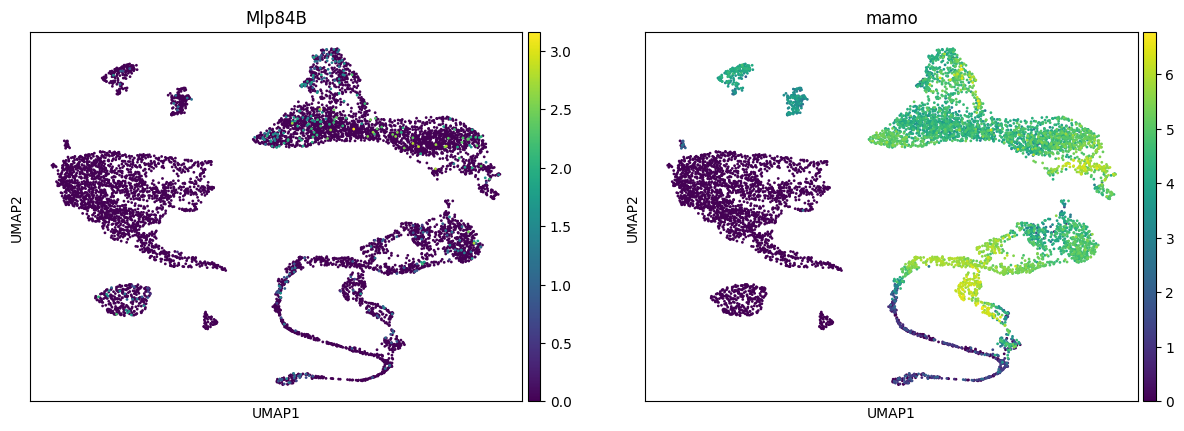

In [24]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=["Mlp84B", "mamo"]) #TODO choose genes (maybe same as before in pca?)

TODO first umap blablba top gene = bad 

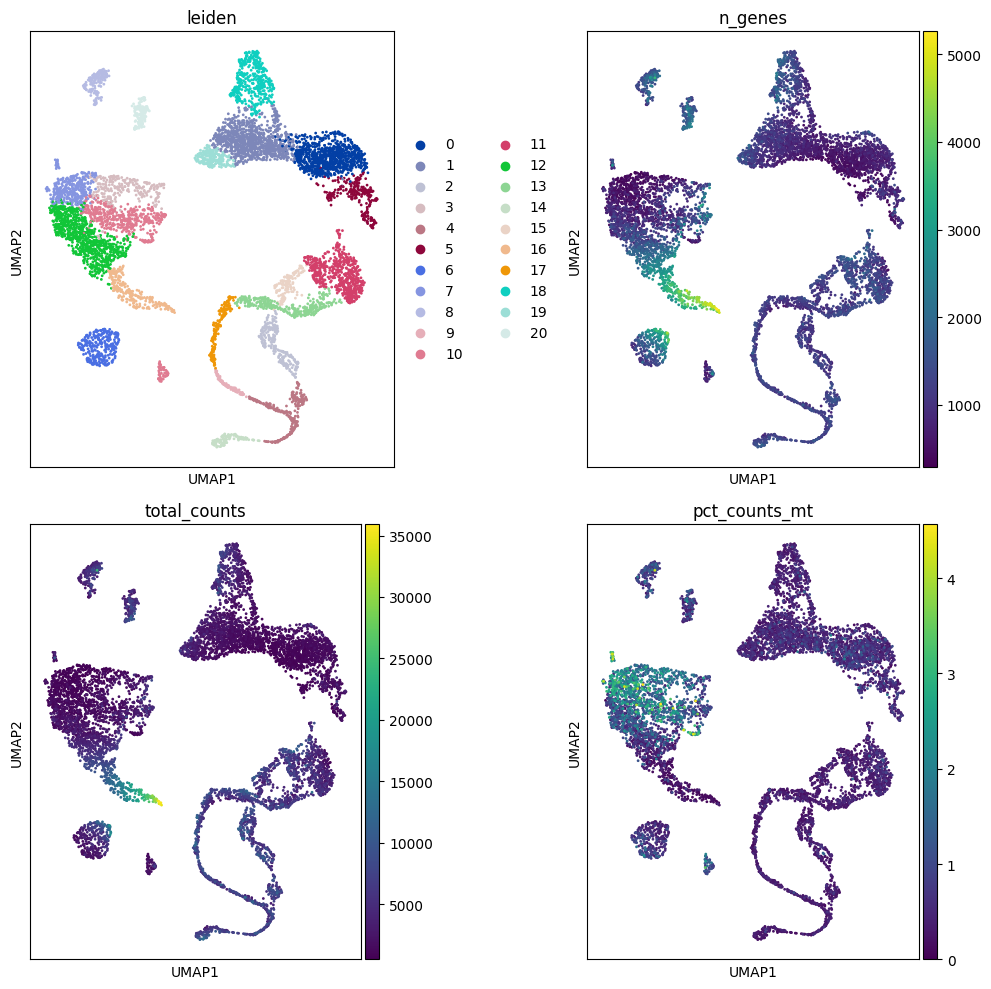

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 

sc.pl.umap(adata, color="leiden", ax=axes[0, 0], show=False)
sc.pl.umap(adata, color="n_genes", ax=axes[0, 1], show=False)
sc.pl.umap(adata, color="total_counts", ax=axes[1, 0], show=False)
sc.pl.umap(adata, color="pct_counts_mt", ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()

Cluster 16 exhibits a high total gene count, which can likely be attributed to its identity as germline cells, particularly young germline cells. These tend to express more genes because they maintain high transcriptional activity to support their pluripotency, self-renewal, and the complex processes of meiosis and differentiation. This is supported by marker gene analysis using the ASAP dataset.



TODO: Germline cells generally have lower mitochondrial gene expression -> here higherrr im confused

### to determine : # pcs & neighbour

- observing clusters seems ok compared to Asap
- 1 cluster with high number of genes 
    - is it artefact or true cluster ? could be due to cell size or very active cells (germ cells) ? 
        - if technical = filter again to remove with max number of genes 
- not much mt = cells are alive 



reproductive cycle of the fly = very active ? could explain this 

### 4) Finding marker genes 

try with other distributions 

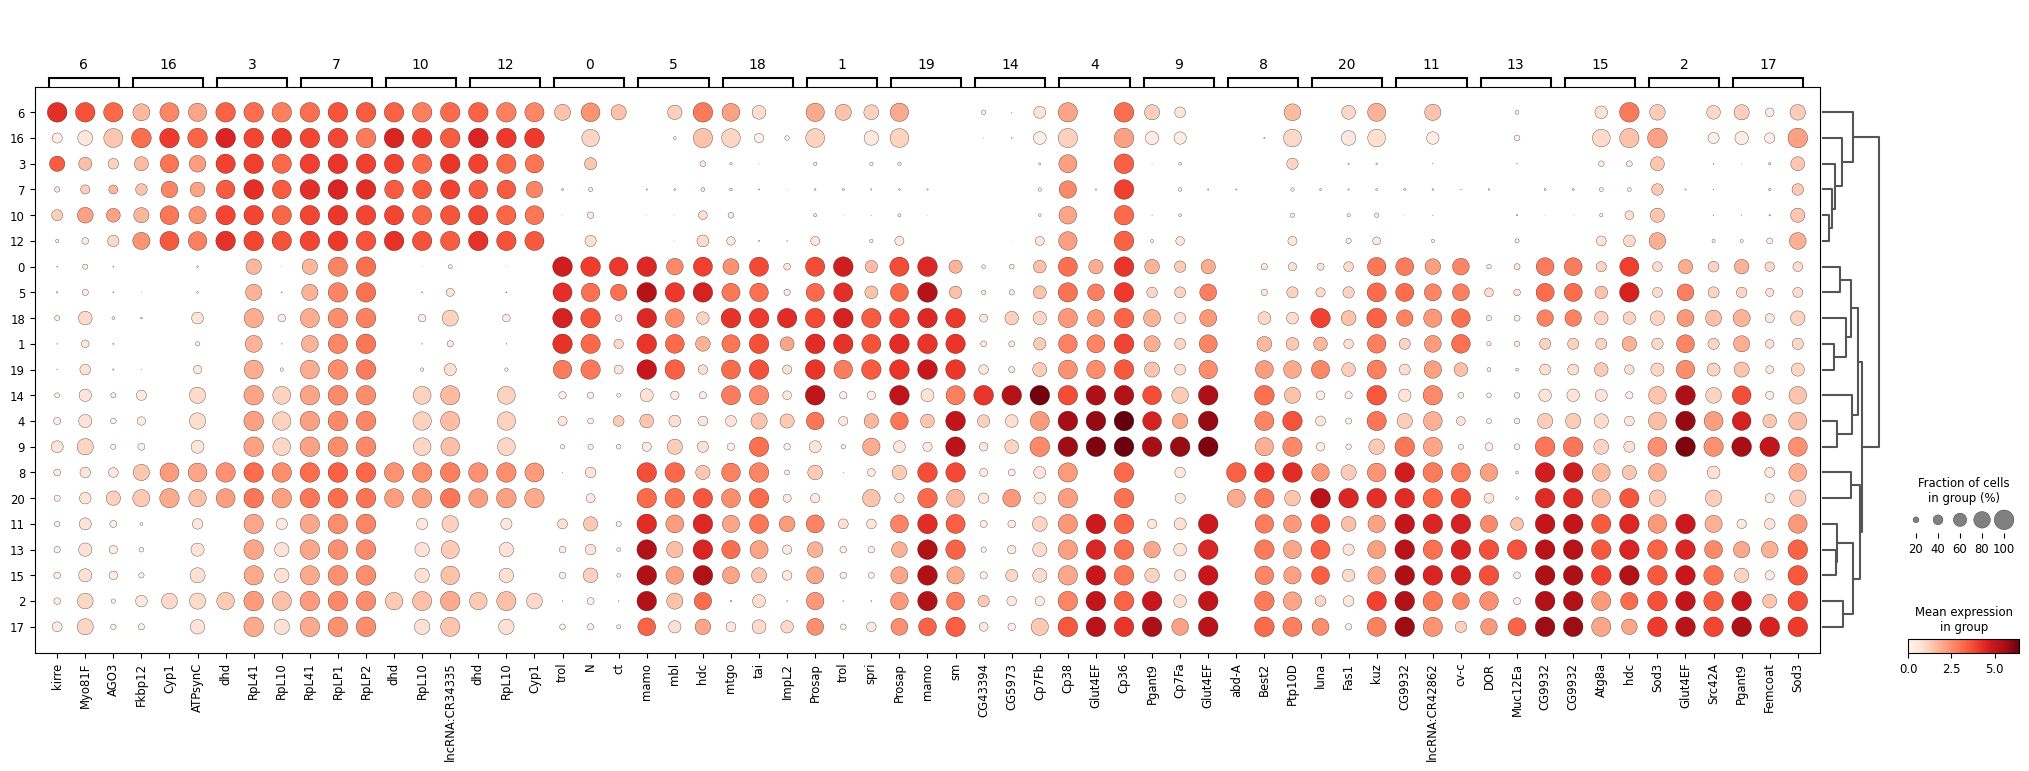

In [20]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='t-test',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
top_markers = markers[markers.pvals_adj < 0.05].groupby('group', observed=False).head(5)

sc.tl.dendrogram(adata, groupby="leiden")

sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden', n_genes=3)

once we have found the markers genes for each group can do violin plots -> TODO: isn't it too much? maybe we can do like here violinplots that group clusters having the same markers

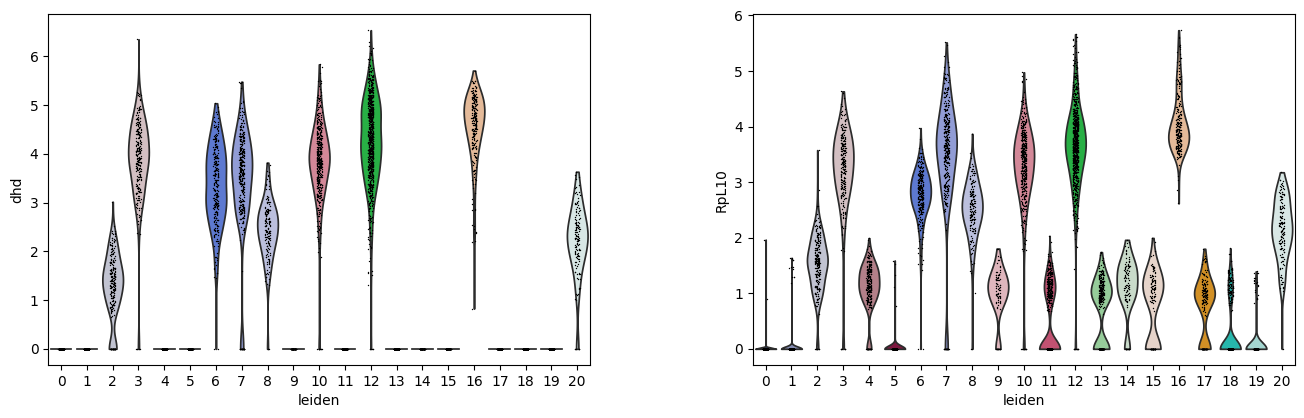

In [23]:
sc.pl.violin(adata, ["dhd", "RpL10"], groupby="leiden")

plots qu'on pourrait faire : 
pour les bons groupes (oviduct) = violin plots des markers genes + coloration cluster umap 
pour les stage germline = texte pourquoi on a pas un bon marker 
+ choisir genre 4 marker pour tout les stages de 5 à 8 = on dit 1 cluster
--> coloration du biiig cluster umap 


/Users/mariannescoglio/anaconda3/envs/singlecell/lib/python3.13/site-packages/scanpy/plotting/_tools/__init__.py:1331: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


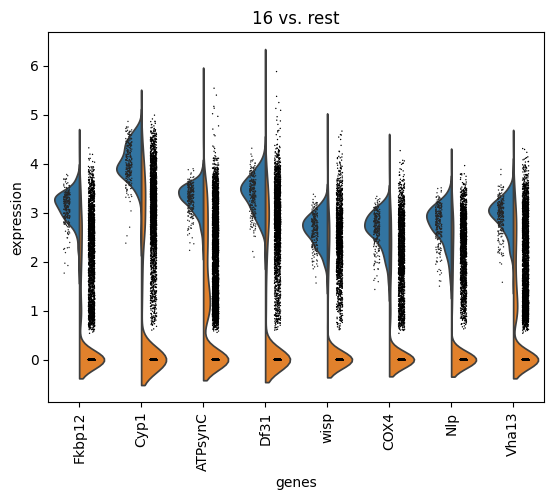

In [21]:
sc.pl.rank_genes_groups_violin(adata, groups="16", n_genes=8) #TODO: jsp si necessaire de faire ca pou chaque group ca faait juste etre confusing non?

### 5) Annotations : finding cell types 

use ASAP (manuel)

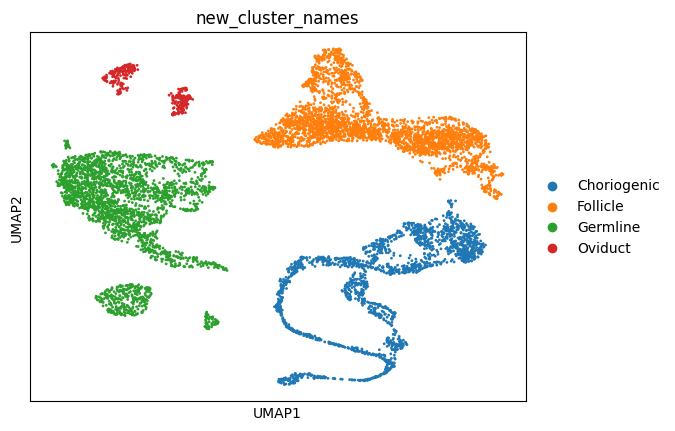

In [29]:
# Define a mapping of old cluster numbers to new group names
cluster_mapping = {
    '0': "Follicle",
    '1': "Follicle",
    '2': "Choriogenic", # and corpus luteum
    '3': "Germline",  
    '4': "Choriogenic",
    '5': "Follicle",
    '6': "Germline", #specifically cell germline cyst in germarium region 2a and 2b
    '7': "Germline",
    '8': "Oviduct", #but also choriogenic
    '9': "Choriogenic",
    '10': "Germline",  
    '11': "Choriogenic", # and corpus luteum
    '12': "Germline",
    '13': "Choriogenic",
    '14': "Choriogenic", # specifically choriogenic main body follicle cell
    '15': "Choriogenic", # and corpus luteum
    '16': "Germline",
    '17': "Choriogenic",
    '18': "Follicle",
    '19': "Follicle",
    '20': "Oviduct"
}

# Map the old cluster labels (Leiden clusters) to new names
adata.obs['new_cluster_names'] = adata.obs['leiden'].map(cluster_mapping)

# You can now use 'new_cluster_names' for plotting or further analysis
sc.pl.umap(adata, color='new_cluster_names')


### add results from asap see excel 


## Conclusion

### image finale regroupe les clusters differents see whatsapp